In [125]:
# Install missing packages to kernel.
! pip install pandas
! pip install matplotlib
! pip install scikit-learn
! pip install graphviz
! pip install nbconvert PyPDF2

  Using cached nbconvert-7.16.4-py3-none-any.whl.metadata (8.5 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)


In [2]:
# Imports
from graphviz import Source
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# CSDS-435: Project #1
# Adam Brennan and Kendall Henley

## Reading Data

In [3]:
# Read Training Data:

training_df = pd.read_csv('training.csv')

In [4]:
# Display Training Data:

training_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Read Testing Data:

testing_df = pd.read_csv('testing.csv')

In [6]:
# Display Testing Data:

testing_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Helper Functions

In [7]:
# get_accuracy(expected_classifications, actual_classifications) - Takes in a list of expected classifications and acutal classifications and computes the accuracy score using the two.
def get_accuracy(expected_classifications, actual_classifications):
    num_classifications = len(expected_classifications)
    num_correct = 0

    for i in range(num_classifications):
        if actual_classifications[i] == expected_classifications[i]:
            num_correct += 1

    return num_correct / num_classifications

In [8]:
# display_image(df, index) - Takes in a DataFrame containing images and displays the image at the corresponding index. If an image is provided, it will be displayed.
def display_image(df=None, index=None, image=None):
    if image is None:
        row = list(df.iloc[index])
        image = np.array(row).reshape(28, 28)
    else:
        image = np.array(image).reshape(28,28)
    plt.imshow(image, interpolation='none')
    plt.show()

In [9]:
# get_dataframe_subset(df, start_index, end_index) - This function takes in a DataFrame 'df' and returns a subset of the DataFrame with rows starting at 'start_index' and ending at 'end_index'.
def get_dataframe_subset(df, start_index, end_index):
    return df.loc[start_index:end_index, :]

In [10]:
# get_image_to_classify(df, i) - This function takes in a DataFrame 'df' containing images and returns the image at index 'i'.
def get_image_to_classify(df, i):
    return pd.DataFrame(data=df.iloc[i]).transpose()

In [11]:
# classification_to_int(classification) - Takes in a classification and converts it to integer form.
def classification_to_int(classification):
    return int(classification[0])

In [12]:
# get_classification(model, image) - Takes in a model and an image and returns the models predicted class for that image.
def get_classification(model, image):
    return classification_to_int(model.predict(image))

In [13]:
# get_classifications(model) - This function takes in a trained model and returns an array containing the classifications of the images in the 'testing.csv' file.
def get_classifications(model, df):
    classifications = []

    for i in range(len(df.index)):
        image = get_image_to_classify(df, i)

        classification = get_classification(model, image)

        classifications.append(classification)

    return classifications

In [14]:
# get_knn_classifier(df) - This function takes in a DataFrame 'df' containing image data and returns a trained KNN classifier.
def get_knn_classifier(df):
    x_train = df.loc[:, df.columns != 'label']
    y_train = np.array(df.label)

    classifier = KNeighborsClassifier(n_neighbors=7)
    classifier.fit(x_train, y_train)

    return classifier

In [15]:
# get_naive_bayes_classifier(df) - This function takes in a DataFrame 'df' containing image data and returns a trained NB classifier.
def get_naive_bayes_classifier(df):
    x_train = df.loc[:, df.columns != 'label']
    y_train = np.array(df.label)

    selector = SelectKBest(f_classif, k=300) 

    classifier = Pipeline([('feature_selection', selector), ('classifier', GaussianNB())])

    classifier.fit(x_train, y_train)

    return classifier

In [16]:
# get_dt_classifier(df) - This function takes in a DataFrame 'df' containing image data and returns a trained DT classifier.
def get_dt_classifier(df):
    x_train = df.loc[:, df.columns != 'label']
    y_train = np.array(df.label)

    classifier = DecisionTreeClassifier(max_depth=15, random_state=42)
    classifier.fit(x_train, y_train)

    return classifier

In [17]:
# get_ann_classifier(df) - This function takes in a DataFrame 'df' containing image data and returns a trained ANN classifier.
def get_ann_classifier(df):
    x_train = df.loc[:, df.columns != 'label']
    y_train = np.array(df.label)

    classifier = MLPClassifier(hidden_layer_sizes=[1024, 512, 256], random_state=42)
    classifier.fit(x_train, y_train)

    return classifier

In [18]:
# get_lr_classifier(df) - This function takes in a DataFrame 'df' containing image data and returns a trained LR classifier.
def get_lr_classifier(df):
    x_train = df.loc[:, df.columns != 'label']
    y_train = np.array(df.label)

    classifier = LogisticRegression(max_iter=1000)

    classifier.fit(x_train, y_train)

    return classifier

In [19]:
# get_lr_classifier(df) - This function takes in a DataFrame 'df' containing image data and returns a trained SVM classifier.
def get_svm_classifier(df):
    x_train = df.loc[:, df.columns != 'label']
    y_train = np.array(df.label)

    classifier = SVC(kernel='poly', degree=5, random_state=42)
    classifier.fit(x_train, y_train)

    return classifier

In [20]:
# get_trained_model(df, t) - This function takes in a DataFrame 'df' containing image data as well as a type 't' of classifier to train and returns the trained classifier.
def get_classifier(df, t):
    if t == 'KNN':
        return get_knn_classifier(df)
    elif t == 'NB':
        return get_naive_bayes_classifier(df)
    elif t == 'DT':
        return get_dt_classifier(df)
    elif t == 'ANN':
        return get_ann_classifier(df)
    elif t == 'LR':
        return get_lr_classifier(df)
    elif t == 'SVM':
        return get_svm_classifier(df)

In [21]:
# get_trained_model(df, t) - This function writes the predictions for 'testing_df' from our best evaluated classification method (ANN) to a file.
def get_output_of_best_method():
    ann = get_classifier(training_df, 'ANN')

    predictions = get_classifications(ann, testing_df)

    output_string = 'Test Label\n'

    for i in range(len(predictions)):
        output_string += str(predictions[i]) + '\n'

    file = open('predictions.txt', 'w')
    file.write(output_string)
    file.close()



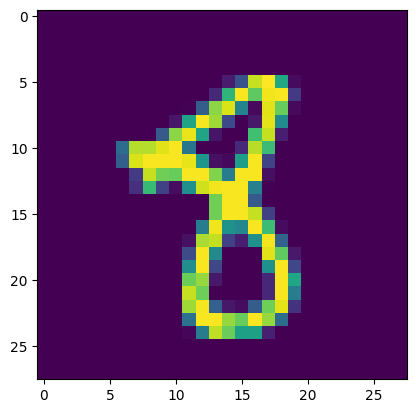

In [22]:
# Example usage for display_image(df, index):
display_image(df=testing_df, index=283)

In [23]:
# Example usage for get_dataframe_subset(df, start_index, end_index):
training_df_subset = get_dataframe_subset(training_df, 0 , 10)

training_df_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classification Method #1: K Nearest Neighbor (KNN) Model

### Model Training

In [24]:
# Get classifier.

knn_classifier = get_classifier(training_df, 'KNN')

Time to train: 0.2s.


In [25]:
# Get test image to classify.

image = get_image_to_classify(testing_df, 10)

image

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


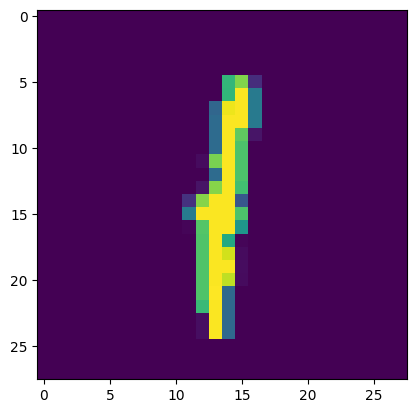

In [26]:
# Display the image.

display_image(image=image)

In [27]:
# Classify the image (should be 1).

get_classification(knn_classifier, image)

1

In [28]:
# Get a subset of images.

images = get_dataframe_subset(training_df, 0, 1000)

In [29]:
# Classify the images.

get_classifications(knn_classifier, images.loc[:, images.columns != 'label'])

Time to classify one image: 0.084s.


### Accuracy Test

In [30]:
# Get accuracy test subset.

knn_large_subset = get_dataframe_subset(training_df, 0, 16799)

In [31]:
# Display subset.

knn_large_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Break into expected classifications and images without their classifications.

knn_small_subset = get_dataframe_subset(training_df, 16800, 21000)
knn_small_subset_expected_classifications = list(knn_small_subset.label)
knn_small_subset_no_classifications = knn_small_subset.loc[:, knn_small_subset.columns != 'label']

In [33]:
# Display expected classifications.

knn_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [34]:
# Display images without classifications.

knn_small_subset_no_classifications

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Get classifier.

knn_large_subset_classifier = get_classifier(knn_large_subset, 'KNN')

In [36]:
# Get classifications output.

knn_small_subset_classifications = get_classifications(knn_large_subset_classifier, knn_small_subset_no_classifications)

In [37]:
# Display classifications.

knn_small_subset_classifications

[6,
 7,
 9,
 0,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 9,
 4,
 0,
 5,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 1,
 6,
 4,
 3,
 1,
 1,
 5,
 9,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 6,
 0,
 2,
 2,
 5,
 4,
 8,
 9,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 0,
 1,
 6,
 2,
 9,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 2,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 1,
 7,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [38]:
# Show expected classifications.

knn_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [39]:
# Get accuracy score.

knn_accuracy = get_accuracy(knn_small_subset_expected_classifications, knn_small_subset_classifications)

print(knn_accuracy)

0.9557142857142857


## Classification Method #2: Naïve Bayes 

### Model Training

In [40]:
# Get classifier.

nb_classifier = get_classifier(training_df, 'NB')

c:\Users\adamj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  51  52  53  54
  55  56  57  59  82  83  84  85 111 112 139 140 141 168 196 224 392 420
 421 448 476 532 533 560 588 616 617 644 645 671 672 673 699 700 701 727
 728 729 730 731 753 754 755 756 757 758 759 760 761 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\adamj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Time to train: 0.4s.


In [41]:
# Get test image to classify.

image = get_image_to_classify(testing_df, 10)

image

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


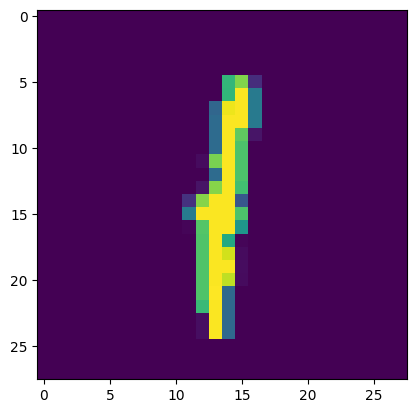

In [42]:
# Display the image.

display_image(image=image)

In [43]:
# Classify the image (should be 1).

get_classification(nb_classifier, image)

1

In [44]:
# Get a subset of images.

images = get_dataframe_subset(training_df, 0, 1000)

In [45]:
# Classify the images.

get_classifications(nb_classifier, images.loc[:, images.columns != 'label'])

Time to classify one image: 0.0052.


### Accuracy Test

In [46]:
# Get accuracy test subset.

nb_large_subset = get_dataframe_subset(training_df, 0, 16799)

In [47]:
# Display subset.

nb_large_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Break into expected classifications and images without their classifications.

nb_small_subset = get_dataframe_subset(training_df, 16800, 21000)
nb_small_subset_expected_classifications = list(nb_small_subset.label)
nb_small_subset_no_classifications = nb_small_subset.loc[:, nb_small_subset.columns != 'label']

In [49]:
# Display expected classifications.

nb_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [50]:
# Display images without classifications.

nb_small_subset_no_classifications

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Get classifier.

nb_large_subset_classifier = get_classifier(knn_large_subset, 'NB')

c:\Users\adamj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  51
  52  53  54  55  56  57  59  82  83  84  85 111 112 139 140 141 168 196
 224 252 280 307 392 420 421 448 476 532 533 560 561 587 588 616 617 644
 645 671 672 673 699 700 701 727 728 729 730 731 753 754 755 756 757 758
 759 760 761 779 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\adamj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [52]:
# Get classifications output.

nb_small_subset_classifications = get_classifications(nb_large_subset_classifier, nb_small_subset_no_classifications)

In [53]:
# Display classifications.

nb_small_subset_classifications

[6,
 8,
 9,
 2,
 9,
 3,
 3,
 4,
 7,
 7,
 7,
 9,
 3,
 6,
 1,
 6,
 5,
 6,
 4,
 8,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 9,
 7,
 8,
 5,
 3,
 9,
 0,
 9,
 0,
 8,
 9,
 9,
 9,
 3,
 1,
 1,
 9,
 6,
 6,
 9,
 3,
 1,
 1,
 3,
 9,
 1,
 0,
 9,
 9,
 3,
 9,
 3,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 9,
 4,
 5,
 3,
 4,
 6,
 0,
 6,
 6,
 9,
 1,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 9,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 9,
 7,
 2,
 6,
 8,
 2,
 9,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 6,
 0,
 9,
 2,
 5,
 4,
 8,
 9,
 2,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 4,
 6,
 6,
 3,
 8,
 2,
 7,
 7,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 9,
 9,
 7,
 3,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 7,
 7,
 3,
 2,
 9,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 9,
 0,
 9,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 6,
 0,
 0,
 7,
 1,
 8,
 1,
 6,
 2,
 9,
 0,
 6,
 5,
 6,
 3,
 8,
 5,
 2,
 3,
 8,
 9,
 2,
 0,
 3,
 8,
 2,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 8,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 1,
 9,
 6,
 6,
 3,
 7,
 3,
 9,
 3,
 9,
 2,
 8,
 9,
 1,


In [54]:
# Show expected classifications.

nb_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [55]:
# Get accuracy score.

nb_accuracy = get_accuracy(nb_small_subset_expected_classifications, nb_small_subset_classifications)

print(nb_accuracy)

0.7426190476190476


## Classification Method #3: Decision Tree

### Model Training

In [56]:
# Get classifier.

dt_classifier = get_classifier(training_df, 'DT')

Time to train: 5.4s.


In [57]:
# Get test image to classify.

image = get_image_to_classify(testing_df, 12)

image

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


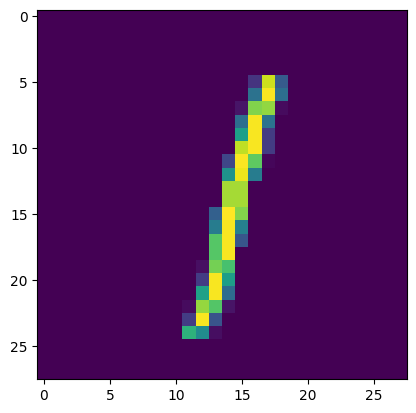

In [58]:
# Display the image.

display_image(image=image)

In [59]:
# Classify the image (should be 1).

get_classification(dt_classifier, image)

1

In [60]:
# Get a subset of images.

images = get_dataframe_subset(training_df, 0, 1000)

In [61]:
# Classify the images.

get_classifications(dt_classifier, images.loc[:, images.columns != 'label'])

Time to classify one image: 0.0051s.


In [62]:
# Export DT visualization.

export_graphviz(
    dt_classifier,
    out_file="decision_tree.dot",
    rounded=True,
    filled=True
)

# Display DT visualization.

visualize = False

if visualize: 
    Source.from_file("decision_tree.dot")

### Accuracy Test

In [63]:
# Get accuracy test subset.

dt_large_subset = get_dataframe_subset(training_df, 0, 16799)

In [64]:
# Display subset.

dt_large_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Break into expected classifications and images without their classifications.

dt_small_subset = get_dataframe_subset(training_df, 16800, 21000)
dt_small_subset_expected_classifications = list(dt_small_subset.label)
dt_small_subset_no_classifications = dt_small_subset.loc[:, dt_small_subset.columns != 'label']

In [66]:
# Display expected classifications.

dt_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [67]:
# Display images without classifications.

dt_small_subset_no_classifications

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Get classifier.

dt_large_subset_classifier = get_classifier(dt_large_subset, 'DT')

In [69]:
# Get classifications output.

dt_small_subset_classifications = get_classifications(dt_large_subset_classifier, dt_small_subset_no_classifications)

In [70]:
# Display classifications.

dt_small_subset_classifications

[6,
 7,
 9,
 2,
 3,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 8,
 6,
 1,
 6,
 5,
 6,
 3,
 8,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 9,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 2,
 8,
 3,
 9,
 3,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 3,
 3,
 0,
 1,
 5,
 0,
 2,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 0,
 3,
 7,
 0,
 1,
 0,
 3,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 3,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 3,
 8,
 8,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 2,
 0,
 9,
 9,
 4,
 1,
 1,
 8,
 9,
 7,
 0,
 5,
 5,
 6,
 2,
 3,
 3,
 2,
 7,
 7,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 4,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 8,
 9,
 6,
 3,
 1,
 3,
 4,
 9,
 3,
 9,
 7,
 3,
 5,
 0,
 6,
 7,
 0,
 1,
 7,
 5,
 1,
 9,
 0,
 2,
 3,
 0,
 7,
 1,
 8,
 1,
 6,
 2,
 7,
 0,
 4,
 8,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 2,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 2,
 2,
 1,
 7,
 6,
 6,
 3,
 4,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [71]:
# Show expected classifications.

dt_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [72]:
# Get accuracy score.

decision_tree_accuracy = get_accuracy(dt_small_subset_expected_classifications, dt_small_subset_classifications)

print(decision_tree_accuracy)

0.8376190476190476


## Classification Method #4: Artificial Neural Network

### Model Training

In [73]:
# Get classifier.

ann_classifier = get_classifier(training_df, 'ANN')

In [74]:
# Get test image to classify.

image = get_image_to_classify(testing_df, 10)

image

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


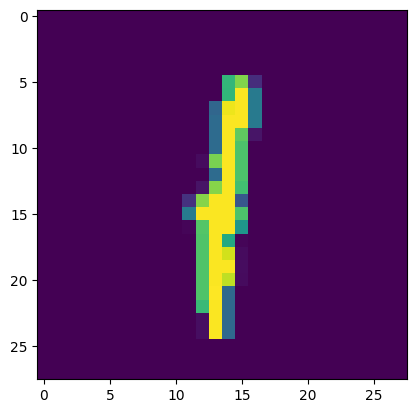

In [75]:
# Display the image.

display_image(image=image)

In [76]:
# Classify the image (should be 1).

get_classification(ann_classifier, image)

1

In [77]:
# Get a subset of images.

images = get_dataframe_subset(training_df, 0, 1000)

In [78]:
# Classify the images.

get_classifications(ann_classifier, images.loc[:, images.columns != 'label'])

[4,
 7,
 3,
 7,
 5,
 2,
 0,
 3,
 6,
 8,
 9,
 4,
 9,
 2,
 1,
 3,
 4,
 4,
 2,
 7,
 7,
 4,
 7,
 9,
 0,
 2,
 2,
 3,
 9,
 1,
 5,
 0,
 6,
 3,
 8,
 9,
 6,
 8,
 9,
 9,
 6,
 3,
 6,
 6,
 2,
 9,
 2,
 0,
 5,
 7,
 8,
 5,
 6,
 2,
 0,
 4,
 7,
 9,
 4,
 6,
 7,
 6,
 0,
 6,
 1,
 7,
 3,
 1,
 4,
 5,
 5,
 4,
 0,
 8,
 0,
 6,
 6,
 9,
 5,
 9,
 3,
 4,
 4,
 5,
 8,
 8,
 2,
 6,
 9,
 3,
 1,
 0,
 4,
 1,
 9,
 2,
 0,
 6,
 0,
 8,
 3,
 2,
 0,
 0,
 0,
 4,
 7,
 2,
 1,
 9,
 9,
 3,
 9,
 6,
 6,
 3,
 1,
 7,
 3,
 6,
 3,
 3,
 2,
 2,
 5,
 8,
 0,
 6,
 7,
 1,
 0,
 0,
 5,
 0,
 0,
 0,
 4,
 0,
 9,
 3,
 0,
 8,
 4,
 9,
 5,
 2,
 2,
 9,
 9,
 2,
 2,
 3,
 6,
 8,
 8,
 7,
 2,
 7,
 9,
 5,
 8,
 4,
 1,
 7,
 8,
 9,
 6,
 7,
 9,
 2,
 2,
 2,
 0,
 7,
 7,
 2,
 9,
 6,
 6,
 8,
 4,
 2,
 5,
 3,
 5,
 4,
 8,
 6,
 2,
 6,
 1,
 4,
 0,
 8,
 4,
 2,
 0,
 6,
 8,
 6,
 4,
 8,
 5,
 5,
 7,
 2,
 9,
 6,
 5,
 2,
 4,
 4,
 4,
 8,
 4,
 1,
 7,
 9,
 5,
 2,
 7,
 2,
 8,
 4,
 9,
 2,
 2,
 9,
 1,
 7,
 3,
 4,
 9,
 1,
 8,
 2,
 2,
 3,
 1,
 7,
 4,
 4,
 5,
 9,
 6,
 9,
 5,
 7,
 6,
 5,


### Accuracy Test

In [79]:
# Get accuracy test subset.

ann_large_subset = get_dataframe_subset(training_df, 0, 16799)

In [80]:
# Display subset.

ann_large_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# Break into expected classifications and images without their classifications.

ann_small_subset = get_dataframe_subset(training_df, 16800, 21000)
ann_small_subset_expected_classifications = list(ann_small_subset.label)
ann_small_subset_no_classifications = ann_small_subset.loc[:, ann_small_subset.columns != 'label']

In [82]:
# Display expected classifications.

ann_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [83]:
# Display images without classifications.

ann_small_subset_no_classifications

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# Get classifier.

ann_large_subset_classifier = get_classifier(ann_large_subset, 'ANN')

In [85]:
# Get classifications output.

ann_small_subset_classifications = get_classifications(ann_large_subset_classifier, ann_small_subset_no_classifications)

In [86]:
# Display classifications.

ann_small_subset_classifications

[6,
 8,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 5,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 9,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 1,
 2,
 0,
 6,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 9,
 2,
 0,
 9,
 9,
 4,
 1,
 1,
 9,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 8,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 1,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [87]:
# Show expected classifications.

ann_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [88]:
# Get accuracy score.

ann_accuracy = get_accuracy(ann_small_subset_expected_classifications, ann_small_subset_classifications)

print(ann_accuracy)

0.9561904761904761


## Classification Method #5: Logistic Regression

### Model Training

In [89]:
# Get classifier.

lr_classifier = get_classifier(training_df, 'LR')

c:\Users\adamj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
# Get test image to classify.

image = get_image_to_classify(testing_df, 10)

image

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


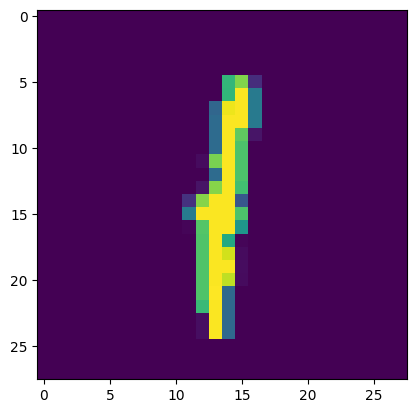

In [91]:
# Display the image.

display_image(image=image)

In [92]:
# Classify the image (should be 1).

get_classification(lr_classifier, image)

1

In [93]:
# Get a subset of images.

images = get_dataframe_subset(training_df, 0, 1000)

In [94]:
# Classify the images.

get_classifications(lr_classifier, images.loc[:, images.columns != 'label'])

[4,
 7,
 3,
 7,
 5,
 2,
 0,
 3,
 6,
 8,
 9,
 4,
 9,
 2,
 1,
 3,
 4,
 4,
 2,
 7,
 7,
 4,
 7,
 9,
 0,
 2,
 2,
 3,
 9,
 1,
 5,
 0,
 6,
 3,
 8,
 9,
 6,
 8,
 9,
 9,
 6,
 3,
 6,
 6,
 2,
 9,
 2,
 0,
 5,
 7,
 8,
 5,
 6,
 2,
 0,
 4,
 7,
 9,
 4,
 6,
 7,
 6,
 0,
 6,
 1,
 7,
 3,
 1,
 4,
 5,
 5,
 4,
 0,
 8,
 0,
 6,
 6,
 9,
 5,
 9,
 3,
 4,
 4,
 5,
 8,
 8,
 2,
 6,
 9,
 3,
 1,
 0,
 4,
 1,
 9,
 2,
 0,
 6,
 0,
 8,
 3,
 2,
 0,
 0,
 0,
 4,
 7,
 2,
 1,
 9,
 9,
 3,
 9,
 6,
 6,
 3,
 1,
 7,
 3,
 6,
 3,
 3,
 2,
 2,
 5,
 8,
 0,
 6,
 7,
 1,
 0,
 0,
 8,
 0,
 0,
 0,
 4,
 0,
 9,
 3,
 0,
 8,
 4,
 9,
 5,
 2,
 2,
 9,
 9,
 2,
 2,
 3,
 6,
 8,
 8,
 7,
 2,
 7,
 9,
 5,
 8,
 4,
 1,
 7,
 8,
 9,
 6,
 7,
 9,
 2,
 2,
 2,
 0,
 7,
 7,
 2,
 9,
 6,
 6,
 5,
 4,
 2,
 5,
 3,
 5,
 4,
 8,
 6,
 2,
 6,
 1,
 4,
 0,
 8,
 4,
 2,
 0,
 6,
 8,
 6,
 4,
 8,
 5,
 5,
 7,
 2,
 9,
 6,
 5,
 2,
 4,
 4,
 4,
 8,
 4,
 1,
 7,
 9,
 3,
 2,
 7,
 2,
 8,
 9,
 9,
 2,
 2,
 9,
 1,
 7,
 3,
 4,
 9,
 1,
 8,
 2,
 2,
 3,
 1,
 7,
 4,
 4,
 5,
 8,
 6,
 9,
 5,
 7,
 6,
 5,


### Accuracy Test

In [95]:
# Get accuracy test subset.

lr_large_subset = get_dataframe_subset(training_df, 0, 16799)

In [96]:
# Display subset.

lr_large_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# Break into expected classifications and images without their classifications.

lr_small_subset = get_dataframe_subset(training_df, 16800, 21000)
lr_small_subset_expected_classifications = list(lr_small_subset.label)
lr_small_subset_no_classifications = lr_small_subset.loc[:, lr_small_subset.columns != 'label']

In [98]:
# Display expected classifications.

lr_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [99]:
# Display images without classifications.

lr_small_subset_no_classifications

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# Get classifier.

lr_large_subset_classifier = get_classifier(lr_large_subset, 'LR')

c:\Users\adamj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
# Get classifications output.

lr_small_subset_classifications = get_classifications(lr_large_subset_classifier, lr_small_subset_no_classifications)

In [102]:
# Display classifications.

lr_small_subset_classifications

[6,
 8,
 9,
 2,
 4,
 5,
 3,
 8,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 3,
 9,
 0,
 3,
 9,
 4,
 4,
 5,
 1,
 1,
 9,
 9,
 6,
 4,
 3,
 1,
 5,
 5,
 4,
 1,
 0,
 8,
 2,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 5,
 0,
 2,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 4,
 0,
 0,
 9,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 0,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 1,
 2,
 5,
 4,
 2,
 7,
 2,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 7,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 4,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 4,
 2,
 9,
 9,
 6,
 3,
 1,
 5,
 0,
 9,
 3,
 2,
 8,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 7,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 9,
 0,
 9,
 5,
 8,
 8,
 8,
 5,
 2,
 8,
 9,
 8,
 2,
 0,
 3,
 8,
 2,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 4,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 1,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 2,
 4,
 2,
 8,
 9,
 1,


In [103]:
# Show expected classifications.

lr_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [104]:
# Get accuracy score.

lr_accuracy = get_accuracy(lr_small_subset_expected_classifications, lr_small_subset_classifications)

print(lr_accuracy)

0.8554761904761905


## Classification Method #6: SVM

### Model Training

In [105]:
# Get classifier.

svm_classifier = get_classifier(training_df, 'SVM')

In [106]:
# Get test image to classify.

image = get_image_to_classify(testing_df, 10)

image

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


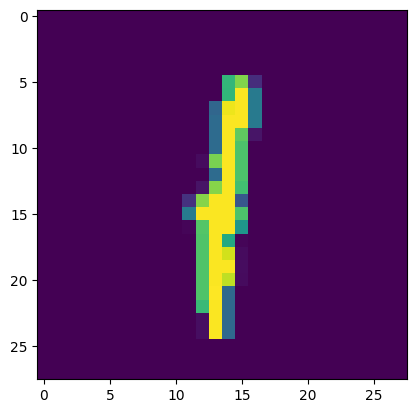

In [107]:
# Display the image.

display_image(image=image)

In [108]:
# Classify the image (should be 1).

get_classification(svm_classifier, image)

1

In [109]:
# Get a subset of images.

images = get_dataframe_subset(training_df, 0, 1000)

In [110]:
# Classify the images.

get_classifications(svm_classifier, images.loc[:, images.columns != 'label'])

[1,
 7,
 3,
 7,
 5,
 2,
 0,
 3,
 6,
 8,
 9,
 4,
 9,
 2,
 1,
 3,
 4,
 4,
 2,
 7,
 7,
 4,
 1,
 9,
 0,
 1,
 2,
 3,
 9,
 1,
 5,
 0,
 6,
 3,
 8,
 9,
 6,
 8,
 9,
 9,
 6,
 3,
 6,
 6,
 2,
 9,
 2,
 0,
 5,
 7,
 8,
 5,
 6,
 2,
 0,
 4,
 7,
 9,
 4,
 6,
 7,
 6,
 0,
 6,
 1,
 7,
 3,
 1,
 4,
 5,
 5,
 4,
 0,
 8,
 0,
 6,
 6,
 9,
 5,
 9,
 3,
 4,
 4,
 5,
 8,
 8,
 2,
 6,
 9,
 3,
 1,
 0,
 4,
 1,
 9,
 1,
 0,
 6,
 0,
 8,
 3,
 2,
 0,
 0,
 0,
 4,
 7,
 2,
 1,
 9,
 9,
 3,
 9,
 6,
 6,
 3,
 1,
 7,
 3,
 6,
 3,
 3,
 1,
 2,
 5,
 8,
 0,
 6,
 7,
 1,
 0,
 0,
 8,
 0,
 0,
 0,
 4,
 0,
 9,
 3,
 0,
 8,
 4,
 9,
 5,
 2,
 2,
 9,
 9,
 2,
 2,
 3,
 6,
 8,
 8,
 7,
 2,
 7,
 9,
 5,
 8,
 4,
 1,
 7,
 8,
 9,
 1,
 7,
 9,
 2,
 2,
 2,
 0,
 7,
 7,
 1,
 9,
 6,
 6,
 8,
 4,
 2,
 5,
 3,
 5,
 1,
 8,
 6,
 2,
 6,
 1,
 4,
 0,
 8,
 4,
 2,
 0,
 1,
 8,
 6,
 4,
 8,
 5,
 5,
 7,
 2,
 9,
 6,
 5,
 2,
 4,
 4,
 4,
 8,
 4,
 1,
 7,
 9,
 5,
 2,
 7,
 2,
 8,
 9,
 9,
 2,
 2,
 9,
 1,
 7,
 3,
 4,
 9,
 1,
 8,
 2,
 2,
 3,
 1,
 7,
 4,
 4,
 5,
 9,
 6,
 9,
 5,
 7,
 6,
 5,


### Accuracy Test

In [111]:
# Get accuracy test subset.

svm_large_subset = get_dataframe_subset(training_df, 0, 16799)

In [112]:
# Display subset.

svm_large_subset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# Break into expected classifications and images without their classifications.

svm_small_subset = get_dataframe_subset(training_df, 16800, 21000)
svm_small_subset_expected_classifications = list(svm_small_subset.label)
svm_small_subset_no_classifications = svm_small_subset.loc[:, svm_small_subset.columns != 'label']

In [114]:
# Display expected classifications.

svm_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [115]:
# Display images without classifications.

svm_small_subset_no_classifications

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# Get classifier.

svm_large_subset_classifier = get_classifier(svm_large_subset, 'SVM')

In [117]:
# Get classifications output.

svm_small_subset_classifications = get_classifications(svm_large_subset_classifier, svm_small_subset_no_classifications)

In [118]:
# Display classifications.

svm_small_subset_classifications

[6,
 7,
 1,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 1,
 9,
 9,
 9,
 4,
 1,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 9,
 4,
 0,
 3,
 9,
 1,
 9,
 5,
 1,
 1,
 9,
 1,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 1,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 2,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 7,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 1,
 1,
 1,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 1,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 1,
 0,
 2,
 7,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 1,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 1,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 1,
 4,
 2,
 5,
 9,
 1,


In [119]:
# Show expected classifications.

svm_small_subset_expected_classifications

[6,
 7,
 9,
 2,
 8,
 5,
 3,
 4,
 7,
 7,
 7,
 4,
 3,
 6,
 1,
 6,
 5,
 6,
 3,
 9,
 9,
 9,
 4,
 8,
 3,
 1,
 7,
 4,
 7,
 8,
 5,
 3,
 9,
 7,
 4,
 0,
 3,
 9,
 5,
 9,
 5,
 1,
 1,
 9,
 2,
 6,
 4,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 5,
 8,
 3,
 9,
 8,
 7,
 1,
 7,
 6,
 1,
 4,
 7,
 2,
 4,
 4,
 5,
 3,
 7,
 2,
 0,
 0,
 9,
 9,
 8,
 2,
 0,
 5,
 6,
 1,
 0,
 5,
 5,
 3,
 7,
 0,
 1,
 0,
 5,
 0,
 0,
 6,
 3,
 9,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 2,
 4,
 8,
 4,
 1,
 0,
 6,
 9,
 8,
 5,
 0,
 2,
 2,
 5,
 4,
 8,
 7,
 3,
 0,
 9,
 9,
 4,
 1,
 1,
 4,
 9,
 7,
 0,
 5,
 5,
 6,
 6,
 3,
 2,
 2,
 7,
 3,
 1,
 7,
 9,
 1,
 2,
 7,
 9,
 4,
 4,
 7,
 5,
 1,
 9,
 5,
 3,
 2,
 4,
 0,
 5,
 7,
 3,
 2,
 7,
 8,
 8,
 3,
 9,
 2,
 9,
 9,
 6,
 3,
 1,
 3,
 0,
 4,
 3,
 9,
 5,
 3,
 5,
 0,
 6,
 8,
 0,
 1,
 7,
 3,
 1,
 9,
 0,
 2,
 0,
 0,
 7,
 1,
 2,
 1,
 6,
 2,
 7,
 0,
 6,
 5,
 8,
 8,
 8,
 5,
 2,
 5,
 9,
 8,
 2,
 0,
 3,
 5,
 3,
 6,
 9,
 2,
 4,
 9,
 7,
 2,
 6,
 8,
 6,
 0,
 7,
 6,
 1,
 3,
 1,
 3,
 2,
 8,
 4,
 6,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 2,
 5,
 9,
 1,


In [120]:
# Get accuracy score.


svm_accuracy = get_accuracy(svm_small_subset_expected_classifications, svm_small_subset_classifications)

print(svm_accuracy)

0.9214285714285714


## Plot Accuracy

C:\Users\adamj\AppData\Local\Temp\ipykernel_22600\2743268310.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


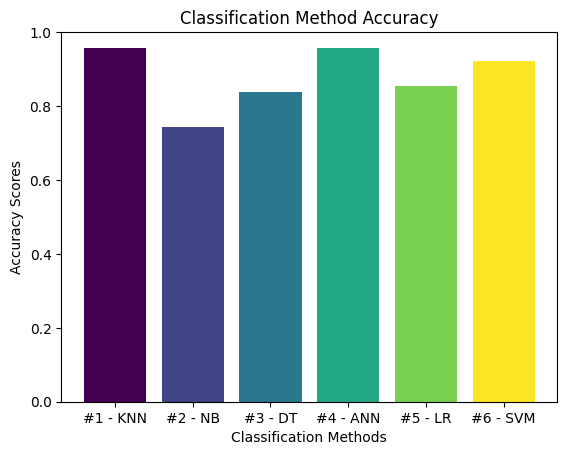

In [121]:
# Plot accuracy scores of the six different classification methods.

x = ['#1 - KNN', '#2 - NB', '#3 - DT', '#4 - ANN', '#5 - LR', '#6 - SVM']
y = [knn_accuracy, nb_accuracy, decision_tree_accuracy, ann_accuracy, lr_accuracy, svm_accuracy]

cmap = cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(x)))
plt.bar(x, y, color=colors)
plt.ylim(0, 1)
plt.xlabel('Classification Methods')
plt.ylabel('Accuracy Scores')
plt.title('Classification Method Accuracy')

plt.show()

## Predicting Using Best Method (ANN)

In [122]:
# Running this cell outputs the predicted classifications from our best method (ANN) to a file for evaluation. NOTE: Running this cell takes about five minutes.

get_output_of_best_method()